In [ ]:
import kagglehub

path = kagglehub.dataset_download("manith04/ddd-testing-frames")
#dddeeee  #ddewewewee  #manith04/gdgdfhfg


100%|██████████| 29.2G/29.2G [05:35<00:00, 93.4MB/s]

Extracting files...


In [ ]:
!echo KAGGLE_API_TOKEN=KGAT_28e717b9ccd1d5f6908afdf6559d8cb4 | touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%file preprocess_faces.py


import os
os.environ.pop('MPLBACKEND', None)  # Remove invalid Colab backend
os.environ['MPLBACKEND'] = 'Agg'

import mediapipe as mp
import os
from pathlib import Path
from tqdm import tqdm
import cv2

mp_face_detection = mp.solutions.face_detection

TARGET_SIZE = 224
MARGIN = 0.2  # expand bounding box by 20%

def crop_face_square(image, detection):
    h, w, _ = image.shape
    bbox = detection.location_data.relative_bounding_box

    x = int(bbox.xmin * w)
    y = int(bbox.ymin * h)
    bw = int(bbox.width * w)
    bh = int(bbox.height * h)

    # Expand bounding box
    cx = x + bw // 2
    cy = y + bh // 2
    size = int(max(bw, bh) * (1 + MARGIN))

    x1 = max(cx - size // 2, 0)
    y1 = max(cy - size // 2, 0)
    x2 = min(cx + size // 2, w)
    y2 = min(cy + size // 2, h)

    face = image[y1:y2, x1:x2]

    if face.size == 0:
        return None

    return cv2.resize(face, (TARGET_SIZE, TARGET_SIZE))


def process_image(image_path, save_path, face_detector):
    img = cv2.imread(str(image_path))
    if img is None:
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_detector.process(img_rgb)

    if results.detections:
        face = crop_face_square(img, results.detections[0])
        if face is not None:
            cv2.imwrite(str(save_path), face)
            return

    # fallback: center crop if face not found
    h, w, _ = img.shape
    min_dim = min(h, w)
    cx, cy = w // 2, h // 2
    crop = img[
        cy - min_dim // 2 : cy + min_dim // 2,
        cx - min_dim // 2 : cx + min_dim // 2,
    ]
    crop = cv2.resize(crop, (TARGET_SIZE, TARGET_SIZE))
    cv2.imwrite(str(save_path), crop)


def process_dataset(input_root, output_root):
    input_root = Path(input_root)
    output_root = Path(output_root)

    with mp_face_detection.FaceDetection(
        model_selection=1, min_detection_confidence=0.5
    ) as face_detector:

        for img_path in tqdm(list(input_root.rglob("*.jpg"))):
            rel_path = img_path.relative_to(input_root)
            save_path = output_root / rel_path
            save_path.parent.mkdir(parents=True, exist_ok=True)

            process_image(img_path, save_path, face_detector)



INPUT_IMAGES = "/content/training_1"
OUTPUT_FACES = "/content/processed_training_1"

process_dataset(INPUT_IMAGES, OUTPUT_FACES)


Overwriting preprocess_faces.py


In [ ]:
%%file preprocess_faces.py

import os
os.environ.pop('MPLBACKEND', None)  # Remove invalid Colab backend
os.environ['MPLBACKEND'] = 'Agg'

import mediapipe as mp
from pathlib import Path
from tqdm import tqdm
import cv2

mp_face_detection = mp.solutions.face_detection

TARGET_SIZE = 224
MARGIN = 0.2  # expand bounding box by 20%

def crop_face_square(image, detection):
    h, w, _ = image.shape
    bbox = detection.location_data.relative_bounding_box

    x = int(bbox.xmin * w)
    y = int(bbox.ymin * h)
    bw = int(bbox.width * w)
    bh = int(bbox.height * h)

    # Expand bounding box
    cx = x + bw // 2
    cy = y + bh // 2
    size = int(max(bw, bh) * (1 + MARGIN))

    x1 = max(cx - size // 2, 0)
    y1 = max(cy - size // 2, 0)
    x2 = min(cx + size // 2, w)
    y2 = min(cy + size // 2, h)

    face = image[y1:y2, x1:x2]

    if face.size == 0:
        return None

    return cv2.resize(face, (TARGET_SIZE, TARGET_SIZE))


def process_image(image_path, save_path, face_detector):
    img = cv2.imread(str(image_path))
    if img is None:
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_detector.process(img_rgb)

    if results.detections:
        face = crop_face_square(img, results.detections[0])
        if face is not None:
            cv2.imwrite(str(save_path), face)
            return

    # fallback: center crop if face not found
    h, w, _ = img.shape
    min_dim = min(h, w)
    cx, cy = w // 2, h // 2
    crop = img[
        cy - min_dim // 2 : cy + min_dim // 2,
        cx - min_dim // 2 : cx + min_dim // 2,
    ]
    crop = cv2.resize(crop, (TARGET_SIZE, TARGET_SIZE))
    cv2.imwrite(str(save_path), crop)


def process_dataset(input_root, output_root, subject_folders):
    input_root = Path(input_root)
    output_root = Path(output_root)

    with mp_face_detection.FaceDetection(
        model_selection=1, min_detection_confidence=0.5
    ) as face_detector:

        for subj in subject_folders:
            subj_path = input_root / subj
            if not subj_path.exists():
                print(f"[WARNING] Subject folder not found: {subj_path}")
                continue

            for img_path in tqdm(list(subj_path.rglob("*.jpg")), desc=f"Processing {subj}"):
                rel_path = img_path.relative_to(input_root)
                save_path = output_root / rel_path
                save_path.parent.mkdir(parents=True, exist_ok=True)

                process_image(img_path, save_path, face_detector)


# ---------------------------
# USER CONFIG
# ---------------------------
INPUT_IMAGES = "/content/training"
OUTPUT_FACES = "/content/processed_training"

# Only these subject folders will be processed
SUBJECT_FOLDERS = ["023", "024", "031", "032", "033", "034", "035", "036"]

# Run
process_dataset(INPUT_IMAGES, OUTPUT_FACES, SUBJECT_FOLDERS)


Writing preprocess_faces.py


In [ ]:
!uv pip install mediapipe opencv-contrib-python  -Uq

In [ ]:
!sudo apt-get install python3.10 python3.10-distutils

In [ ]:
!uv python install 3.10
!export PATH="/root/.local/bin:$PATH"
!which python3.10


In [ ]:
%%bash
uv pip install --python python3.10 mediapipe==0.10.9 opencv-python tqdm matplotlib -q

In [ ]:
!python3.10 preprocess_faces.py

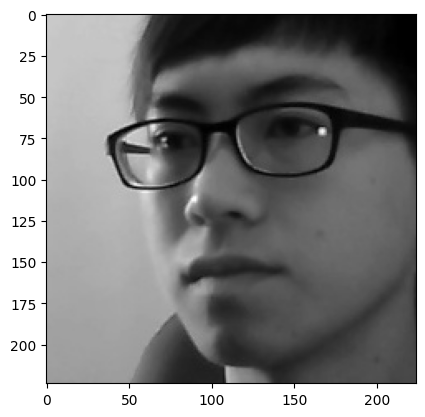

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

data = "processed_training_1/001/01_glasses/001_glasses_yawning_001794_1.jpg"

# Read image file into NumPy array
img = mpimg.imread(data)

# Display
plt.imshow(img)
# plt.axis('off')  # Optional: hide axes/ticks
plt.show()

# Validation

In [ ]:
import cv2
import os
from pathlib import Path
from tqdm import tqdm

VIDEO_EXTENSIONS = {".avi", ".mp4"}

def read_annotation_file(txt_path):
    """Read NTHU-DDD annotation files (single line, one digit per frame)"""
    with open(txt_path, "r") as f:
        content = f.read().strip()
    return [int(ch) for ch in content if ch.isdigit()]

def fix_night_scenario_name(stem):
    """
    Fix ONLY the inconsistent 'nightnoglasses' → 'night_noglasses' mapping.
    'nightglasses' remains unchanged (correct as-is).
    """
    # ONLY fix nightnoglasses → night_noglasses
    return stem.replace("nightnoglasses", "night_noglasses")

def find_annotation_path(video_path):
    """
    Find annotation with fallbacks for evaluation dataset inconsistencies:
      - nightnoglasses → night_noglasses (missing underscore)
      - _mix → _mixing variant (some annotations use "mixing")
    """
    # Try 1: Exact match
    annot_path = video_path.parent / f"{video_path.stem}_drowsiness.txt"
    if annot_path.exists():
        return annot_path

    # Try 2: Fix ONLY nightnoglasses → night_noglasses
    fixed_stem = fix_night_scenario_name(video_path.stem)
    if fixed_stem != video_path.stem:
        annot_path = video_path.parent / f"{fixed_stem}_drowsiness.txt"
        if annot_path.exists():
            return annot_path

    # Try 3: Handle "mixing" vs "mix" suffix variant
    if "_mix" in video_path.stem:
        alt_stem = video_path.stem.replace("_mix", "_mixing")
        annot_path = video_path.parent / f"{alt_stem}_drowsiness.txt"
        if annot_path.exists():
            return annot_path

        # Also try fixed version of "mixing"
        alt_stem_fixed = fix_night_scenario_name(alt_stem)
        annot_path = video_path.parent / f"{alt_stem_fixed}_drowsiness.txt"
        if annot_path.exists():
            return annot_path

    return None

def extract_frames_from_video(video_path, output_root):
    video_path = Path(video_path)
    is_evaluation = "_mix" in video_path.stem.lower()

    if is_evaluation:
        # Parse: e.g., "004_nightnoglasses_mix.mp4" → parts = ["004", "nightnoglasses", "mix"]
        parts = video_path.stem.split('_')
        if len(parts) >= 3:
            subject_id = parts[0]
            scenario_raw = parts[1]
            behavior = "mix"

            # For filename output: clean scenario name (remove "night_" prefix if present)
            scenario_clean = scenario_raw.replace("night_", "") if scenario_raw.startswith("night_") else scenario_raw

            subject_folder = video_path.parent.name
            # Use fixed scenario name for folder (with underscore if needed)
            scenario_folder = f"{subject_id}_{fix_night_scenario_name(scenario_raw)}"
        else:
            print(f"[WARNING] Unexpected eval filename format: {video_path.name}")
            return
    else:
        # TRAINING: standard structure
        subject_folder = video_path.parents[1].name
        scenario_full = video_path.parent.name
        scenario_clean = scenario_full.split('_', 1)[-1]
        behavior = video_path.stem
        subject_id = subject_folder
        scenario_folder = scenario_full

    # Find annotation
    annot_path = find_annotation_path(video_path)
    if annot_path is None:
        print(f"[WARNING] Annotation missing for: {video_path.name}")
        print(f"  Tried: {video_path.parent / f'{video_path.stem}_drowsiness.txt'}")
        print(f"  Tried: {video_path.parent / f'{fix_night_scenario_name(video_path.stem)}_drowsiness.txt'}")
        return

    labels = read_annotation_file(annot_path)

    # Open video
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"[ERROR] Cannot open video: {video_path}")
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        print(f"[WARNING] Empty video: {video_path}")
        cap.release()
        return

    # Create output directory
    save_dir = Path(output_root) / subject_folder / scenario_folder
    save_dir.mkdir(parents=True, exist_ok=True)

    # Extract frames
    frames_to_extract = min(total_frames, len(labels))
    for frame_idx in range(frames_to_extract):
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        label = labels[frame_idx]
        filename = (
            f"{subject_id}_{scenario_clean}_{behavior}_"
            f"{frame_idx:06d}_{label}.jpg"
        )
        cv2.imwrite(str(save_dir / filename), frame)

    cap.release()
    print(f"[OK] {frames_to_extract:4d} frames → {subject_folder}/{scenario_folder}")

def process_dataset(root_dir, output_dir):
    root_dir = Path(root_dir)
    video_files = sorted([
        p for p in root_dir.rglob("*")
        if p.suffix.lower() in VIDEO_EXTENSIONS
    ])

    print(f"Found {len(video_files)} video files to process\n")
    successes = 0
    for video_path in tqdm(video_files, desc="Extracting frames"):
        annot_path = find_annotation_path(video_path)
        if annot_path:
            extract_frames_from_video(video_path, output_dir)
            successes += 1
        else:
            print(f"[FAIL] No annotation for: {video_path.relative_to(root_dir)}")

    print(f"\n✓ Processed {successes}/{len(video_files)} videos successfully")
    print(f"✓ Output directory: {output_dir}")

# Usage
dataset_path = "/root/.cache/kagglehub/datasets/manith04/gdgdfhfg/versions/1"
OUTPUT_ROOT = "/content/validation"

process_dataset(dataset_path, OUTPUT_ROOT)

Found 20 video files to process



Extracting frames:   5%|▌         | 1/20 [00:08<02:32,  8.01s/it]

[OK] 3045 frames → 004/004_glasses


Extracting frames:  10%|█         | 2/20 [00:21<03:17, 10.97s/it]

[OK] 5396 frames → 004/004_nightglasses


Extracting frames:  15%|█▌        | 3/20 [00:49<05:20, 18.83s/it]

[OK] 11726 frames → 004/004_night_noglasses


Extracting frames:  20%|██        | 4/20 [01:14<05:41, 21.37s/it]

[OK] 10203 frames → 004/004_noglasses


Extracting frames:  25%|██▌       | 5/20 [01:22<04:09, 16.65s/it]

[OK] 3504 frames → 004/004_sunglasses


Extracting frames:  30%|███       | 6/20 [01:29<03:05, 13.23s/it]

[OK] 2550 frames → 022/022_glasses


Extracting frames:  35%|███▌      | 7/20 [01:48<03:15, 15.01s/it]

[OK] 8200 frames → 022/022_nightglasses


Extracting frames:  40%|████      | 8/20 [02:08<03:19, 16.65s/it]

[OK] 8615 frames → 022/022_night_noglasses


Extracting frames:  45%|████▌     | 9/20 [02:48<04:24, 24.01s/it]

[OK] 16847 frames → 022/022_noglasses


Extracting frames:  50%|█████     | 10/20 [02:55<03:06, 18.69s/it]

[OK] 2565 frames → 022/022_sunglasses


Extracting frames:  55%|█████▌    | 11/20 [03:38<03:54, 26.11s/it]

[OK] 17458 frames → 026/026_glasses


Extracting frames:  60%|██████    | 12/20 [03:44<02:40, 20.03s/it]

[OK] 2849 frames → 026/026_nightglasses


Extracting frames:  65%|██████▌   | 13/20 [04:00<02:12, 18.98s/it]

[OK] 6778 frames → 026/026_night_noglasses


Extracting frames:  70%|███████   | 14/20 [04:34<02:20, 23.33s/it]

[OK] 12702 frames → 026/026_noglasses


Extracting frames:  75%|███████▌  | 15/20 [05:14<02:22, 28.49s/it]

[OK] 13133 frames → 026/026_sunglasses


Extracting frames:  80%|████████  | 16/20 [05:52<02:05, 31.45s/it]

[OK] 14300 frames → 030/030_glasses


Extracting frames:  85%|████████▌ | 17/20 [06:31<01:40, 33.61s/it]

[OK] 16473 frames → 030/030_nightglasses


Extracting frames:  90%|█████████ | 18/20 [06:37<00:50, 25.39s/it]

[OK] 2658 frames → 030/030_night_noglasses


Extracting frames:  95%|█████████▌| 19/20 [06:50<00:21, 21.66s/it]

[OK] 5249 frames → 030/030_noglasses


Extracting frames: 100%|██████████| 20/20 [07:12<00:00, 21.64s/it]

[OK] 9008 frames → 030/030_sunglasses

✓ Processed 20/20 videos successfully
✓ Output directory: /content/validation


In [ ]:
%%file preprocess_faces.py


import os
os.environ.pop('MPLBACKEND', None)  # Remove invalid Colab backend
os.environ['MPLBACKEND'] = 'Agg'

import mediapipe as mp
import os
from pathlib import Path
from tqdm import tqdm
import cv2

mp_face_detection = mp.solutions.face_detection

TARGET_SIZE = 224
MARGIN = 0.2  # expand bounding box by 20%

def crop_face_square(image, detection):
    h, w, _ = image.shape
    bbox = detection.location_data.relative_bounding_box

    x = int(bbox.xmin * w)
    y = int(bbox.ymin * h)
    bw = int(bbox.width * w)
    bh = int(bbox.height * h)

    # Expand bounding box
    cx = x + bw // 2
    cy = y + bh // 2
    size = int(max(bw, bh) * (1 + MARGIN))

    x1 = max(cx - size // 2, 0)
    y1 = max(cy - size // 2, 0)
    x2 = min(cx + size // 2, w)
    y2 = min(cy + size // 2, h)

    face = image[y1:y2, x1:x2]

    if face.size == 0:
        return None

    return cv2.resize(face, (TARGET_SIZE, TARGET_SIZE))


def process_image(image_path, save_path, face_detector):
    img = cv2.imread(str(image_path))
    if img is None:
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_detector.process(img_rgb)

    if results.detections:
        face = crop_face_square(img, results.detections[0])
        if face is not None:
            cv2.imwrite(str(save_path), face)
            return

    # fallback: center crop if face not found
    h, w, _ = img.shape
    min_dim = min(h, w)
    cx, cy = w // 2, h // 2
    crop = img[
        cy - min_dim // 2 : cy + min_dim // 2,
        cx - min_dim // 2 : cx + min_dim // 2,
    ]
    crop = cv2.resize(crop, (TARGET_SIZE, TARGET_SIZE))
    cv2.imwrite(str(save_path), crop)


def process_dataset(input_root, output_root):
    input_root = Path(input_root)
    output_root = Path(output_root)

    with mp_face_detection.FaceDetection(
        model_selection=1, min_detection_confidence=0.5
    ) as face_detector:

        for img_path in tqdm(list(input_root.rglob("*.jpg"))):
            rel_path = img_path.relative_to(input_root)
            save_path = output_root / rel_path
            save_path.parent.mkdir(parents=True, exist_ok=True)

            process_image(img_path, save_path, face_detector)



INPUT_IMAGES = "/content/validation"
OUTPUT_FACES = "/content/processed_validation"

process_dataset(INPUT_IMAGES, OUTPUT_FACES)


Overwriting preprocess_faces.py


# Testing

In [ ]:
import cv2
import os
from pathlib import Path
from tqdm import tqdm

VIDEO_EXTENSIONS = {".avi", ".mp4"}

def read_annotation_file(txt_path):
    """Read NTHU-DDD annotation files (single line, one digit per frame)"""
    with open(txt_path, "r") as f:
        content = f.read().strip()
    return [int(ch) for ch in content if ch.isdigit()]

def find_annotation_path(video_path):
    """
    Search annotations in the CORRECT location for this dataset:
      Testing_Dataset/test_label_txt/wh/{stem}_mixing_drowsiness.txt
    """
    # PRIMARY location (your dataset structure)
    labels_dir = video_path.parent / "test_label_txt" / "wh"

    # Pattern: _mix → _mixing (standard conversion)
    alt_stem = video_path.stem.replace("_mix", "_mixing")
    annot_path = labels_dir / f"{alt_stem}_drowsiness.txt"

    if annot_path.exists():
        return annot_path, labels_dir

    # Fallback: exact match (just in case)
    annot_path = labels_dir / f"{video_path.stem}_drowsiness.txt"
    if annot_path.exists():
        return annot_path, labels_dir

    return None, labels_dir

def extract_frames_from_video(video_path, output_root):
    video_path = Path(video_path)

    # Parse filename: "010_nightglasses_mix.mp4" → ["010", "nightglasses", "mix"]
    parts = video_path.stem.split('_')
    if len(parts) < 3:
        print(f"[WARNING] Unexpected filename format: {video_path.name}")
        return False

    subject_id = parts[0]
    scenario_raw = parts[1]
    behavior = "mix"
    scenario_clean = scenario_raw.replace("night_", "") if scenario_raw.startswith("night_") else scenario_raw

    # Find annotation
    annot_path, labels_dir = find_annotation_path(video_path)

    if annot_path is None:
        print(f"\n[FAIL] No annotation for: {video_path.name}")
        print(f"  Expected at: {labels_dir.relative_to(video_path.parent)}/{video_path.stem.replace('_mix', '_mixing')}_drowsiness.txt")
        print(f"  Directory exists? {'✓ YES' if labels_dir.exists() else '✗ NO'}")
        if labels_dir.exists():
            print(f"  First 3 files in annotation dir:")
            for i, f in enumerate(sorted(labels_dir.glob("*.txt"))[:3], 1):
                print(f"    {i}. {f.name}")
        return False

    # Read labels
    labels = read_annotation_file(annot_path)

    # Open video
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"[ERROR] Cannot open video: {video_path}")
        return False

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        print(f"[WARNING] Empty video: {video_path}")
        cap.release()
        return False

    # Create output directory
    save_dir = Path(output_root) / subject_id / scenario_raw
    save_dir.mkdir(parents=True, exist_ok=True)

    # Extract frames
    frames_to_extract = min(total_frames, len(labels))
    for frame_idx in range(frames_to_extract):
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        label = labels[frame_idx]
        filename = f"{subject_id}_{scenario_clean}_{behavior}_{frame_idx:06d}_{label}.jpg"
        cv2.imwrite(str(save_dir / filename), frame)

    cap.release()
    print(f"[OK] {frames_to_extract:4d} frames → {subject_id}/{scenario_raw}")
    return True

def process_dataset(root_dir, output_dir):
    root_dir = Path(root_dir)
    video_files = sorted([
        p for p in root_dir.glob("*")
        if p.suffix.lower() in VIDEO_EXTENSIONS and not p.name.startswith('.')
    ])

    print(f"📁 Found {len(video_files)} videos in: {root_dir}")
    print(f"🔍 Annotations expected at: test_label_txt/wh/\n")

    successes = 0
    failures = []

    for video_path in tqdm(video_files, desc="Extracting frames"):
        if extract_frames_from_video(video_path, output_dir):
            successes += 1
        else:
            failures.append(video_path.name)

    # Summary
    print(f"\n{'='*70}")
    print(f"✅ SUCCESS: {successes}/{len(video_files)} videos processed")
    print(f"{'='*70}")

    if failures:
        print(f"\n❌ Failed videos ({len(failures)}):")
        for fname in failures:
            print(f"   • {fname}")
    else:
        print(f"\n🎉 All videos processed successfully!")

    print(f"\n📤 Output saved to: {output_dir}")

# Usage - ADJUST PATHS AS NEEDED
TESTING_DATASET = "/root/.cache/kagglehub/datasets/manith04/ky87retdgfu7t/versions/1/Testing_Dataset"
OUTPUT_ROOT = "/content/testing_frames"

process_dataset(TESTING_DATASET, OUTPUT_ROOT)

📁 Found 70 videos in: /root/.cache/kagglehub/datasets/manith04/ky87retdgfu7t/versions/1/Testing_Dataset
🔍 Annotations expected at: test_label_txt/wh/



Extracting frames:   1%|▏         | 1/70 [00:48<55:28, 48.25s/it]

[OK] 19813 frames → 003/glasses


Extracting frames:   3%|▎         | 2/70 [00:55<27:01, 23.84s/it]

[OK] 2687 frames → 003/nightglasses


Extracting frames:   4%|▍         | 3/70 [01:15<25:06, 22.48s/it]

[OK] 8814 frames → 003/nightnoglasses


Extracting frames:   6%|▌         | 4/70 [01:36<23:50, 21.68s/it]

[OK] 7972 frames → 003/noglasses


Extracting frames:   7%|▋         | 5/70 [02:10<28:21, 26.17s/it]

[OK] 14364 frames → 003/sunglasses


Extracting frames:   9%|▊         | 6/70 [02:34<27:14, 25.54s/it]

[OK] 10065 frames → 010/glasses


Extracting frames:  10%|█         | 7/70 [03:05<28:44, 27.37s/it]

[OK] 13112 frames → 010/nightglasses


Extracting frames:  11%|█▏        | 8/70 [03:46<32:36, 31.56s/it]

[OK] 17110 frames → 010/nightnoglasses


Extracting frames:  13%|█▎        | 9/70 [03:52<24:03, 23.67s/it]

[OK] 2236 frames → 010/noglasses


Extracting frames:  14%|█▍        | 10/70 [04:07<20:47, 20.80s/it]

[OK] 5958 frames → 010/sunglasses


Extracting frames:  16%|█▌        | 11/70 [04:27<20:14, 20.58s/it]

[OK] 8647 frames → 011/glasses


Extracting frames:  17%|█▋        | 12/70 [05:03<24:30, 25.35s/it]

[OK] 15171 frames → 011/nightglasses


Extracting frames:  19%|█▊        | 13/70 [05:38<26:55, 28.34s/it]

[OK] 13919 frames → 011/nightnoglasses


Extracting frames:  20%|██        | 14/70 [05:44<20:01, 21.45s/it]

[OK] 2251 frames → 011/noglasses


Extracting frames:  21%|██▏       | 15/70 [06:12<21:39, 23.62s/it]

[OK] 10649 frames → 011/sunglasses


Extracting frames:  23%|██▎       | 16/70 [06:42<22:54, 25.45s/it]

[OK] 10997 frames → 014/glasses


Extracting frames:  24%|██▍       | 17/70 [07:18<25:19, 28.67s/it]

[OK] 14663 frames → 014/nightglasses


Extracting frames:  26%|██▌       | 18/70 [07:25<19:10, 22.12s/it]

[OK] 2803 frames → 014/nightnoglasses


Extracting frames:  27%|██▋       | 19/70 [07:46<18:27, 21.72s/it]

[OK] 7882 frames → 014/noglasses


Extracting frames:  29%|██▊       | 20/70 [08:20<21:15, 25.51s/it]

[OK] 13118 frames → 014/sunglasses


Extracting frames:  30%|███       | 21/70 [08:57<23:41, 29.00s/it]

[OK] 14263 frames → 016/glasses


Extracting frames:  31%|███▏      | 22/70 [09:31<24:25, 30.54s/it]

[OK] 14588 frames → 016/nightglasses


Extracting frames:  33%|███▎      | 23/70 [09:39<18:24, 23.51s/it]

[OK] 2743 frames → 016/nightnoglasses


Extracting frames:  34%|███▍      | 24/70 [10:02<18:04, 23.57s/it]

[OK] 9014 frames → 016/noglasses


Extracting frames:  36%|███▌      | 25/70 [10:35<19:48, 26.41s/it]

[OK] 12933 frames → 016/sunglasses


Extracting frames:  37%|███▋      | 26/70 [10:46<15:52, 21.65s/it]

[OK] 3992 frames → 017/glasses


Extracting frames:  39%|███▊      | 27/70 [11:07<15:27, 21.58s/it]

[OK] 8548 frames → 017/nightglasses


Extracting frames:  40%|████      | 28/70 [11:48<19:06, 27.30s/it]

[OK] 14621 frames → 017/nightnoglasses


Extracting frames:  41%|████▏     | 29/70 [12:29<21:29, 31.46s/it]

[OK] 15931 frames → 017/noglasses


Extracting frames:  43%|████▎     | 30/70 [12:38<16:26, 24.65s/it]

[OK] 3263 frames → 017/sunglasses


Extracting frames:  44%|████▍     | 31/70 [13:31<21:37, 33.27s/it]

[OK] 20448 frames → 018/glasses


Extracting frames:  46%|████▌     | 32/70 [13:38<15:56, 25.17s/it]

[OK] 2400 frames → 018/nightglasses


Extracting frames:  47%|████▋     | 33/70 [14:03<15:31, 25.18s/it]

[OK] 10672 frames → 018/nightnoglasses


Extracting frames:  49%|████▊     | 34/70 [14:37<16:41, 27.81s/it]

[OK] 13568 frames → 018/noglasses


Extracting frames:  50%|█████     | 35/70 [15:32<21:04, 36.13s/it]

[OK] 21486 frames → 018/sunglasses


Extracting frames:  51%|█████▏    | 36/70 [16:15<21:33, 38.05s/it]

[OK] 13360 frames → 019/glasses


Extracting frames:  53%|█████▎    | 37/70 [16:22<15:53, 28.90s/it]

[OK] 3118 frames → 019/nightglasses


Extracting frames:  54%|█████▍    | 38/70 [16:51<15:22, 28.82s/it]

[OK] 10593 frames → 019/nightnoglasses


Extracting frames:  56%|█████▌    | 39/70 [17:31<16:37, 32.18s/it]

[OK] 15371 frames → 019/noglasses


Extracting frames:  57%|█████▋    | 40/70 [18:13<17:32, 35.07s/it]

[OK] 16134 frames → 019/sunglasses


Extracting frames:  59%|█████▊    | 41/70 [18:19<12:50, 26.56s/it]

[OK] 2387 frames → 021/glasses


Extracting frames:  60%|██████    | 42/70 [18:38<11:16, 24.16s/it]

[OK] 7637 frames → 021/nightglasses


Extracting frames:  61%|██████▏   | 43/70 [19:09<11:48, 26.25s/it]

[OK] 12906 frames → 021/nightnoglasses


Extracting frames:  63%|██████▎   | 44/70 [19:58<14:17, 32.97s/it]

[OK] 18821 frames → 021/noglasses


Extracting frames:  64%|██████▍   | 45/70 [20:06<10:40, 25.60s/it]

[OK] 3121 frames → 021/sunglasses


Extracting frames:  66%|██████▌   | 46/70 [20:34<10:26, 26.12s/it]

[OK] 10691 frames → 025/glasses


Extracting frames:  67%|██████▋   | 47/70 [21:15<11:45, 30.69s/it]

[OK] 16950 frames → 025/nightglasses


Extracting frames:  69%|██████▊   | 48/70 [22:07<13:34, 37.02s/it]

[OK] 21052 frames → 025/nightnoglasses


Extracting frames:  70%|███████   | 49/70 [22:15<09:54, 28.31s/it]

[OK] 2961 frames → 025/noglasses


Extracting frames:  71%|███████▏  | 50/70 [22:41<09:16, 27.80s/it]

[OK] 9824 frames → 025/sunglasses


Extracting frames:  73%|███████▎  | 51/70 [22:48<06:50, 21.59s/it]

[OK] 2382 frames → 027/glasses


Extracting frames:  74%|███████▍  | 52/70 [23:10<06:27, 21.55s/it]

[OK] 8674 frames → 027/nightglasses


Extracting frames:  76%|███████▌  | 53/70 [23:41<06:52, 24.29s/it]

[OK] 11882 frames → 027/nightnoglasses


Extracting frames:  77%|███████▋  | 54/70 [24:25<08:07, 30.47s/it]

[OK] 16531 frames → 027/noglasses


Extracting frames:  79%|███████▊  | 55/70 [24:33<05:55, 23.70s/it]

[OK] 2758 frames → 027/sunglasses


Extracting frames:  80%|████████  | 56/70 [24:52<05:10, 22.20s/it]

[OK] 7524 frames → 028/glasses


Extracting frames:  81%|████████▏ | 57/70 [25:19<05:06, 23.54s/it]

[OK] 11027 frames → 028/nightglasses


Extracting frames:  83%|████████▎ | 58/70 [26:09<06:17, 31.50s/it]

[OK] 15437 frames → 028/nightnoglasses


Extracting frames:  84%|████████▍ | 59/70 [26:17<04:30, 24.55s/it]

[OK] 2768 frames → 028/noglasses


Extracting frames:  86%|████████▌ | 60/70 [26:39<03:56, 23.66s/it]

[OK] 8032 frames → 028/sunglasses


Extracting frames:  87%|████████▋ | 61/70 [27:22<04:24, 29.41s/it]

[OK] 15392 frames → 029/glasses


Extracting frames:  89%|████████▊ | 62/70 [28:09<04:39, 34.93s/it]

[OK] 19943 frames → 029/nightglasses


Extracting frames:  90%|█████████ | 63/70 [28:16<03:04, 26.31s/it]

[OK] 2343 frames → 029/nightnoglasses


Extracting frames:  91%|█████████▏| 64/70 [28:38<02:31, 25.29s/it]

[OK] 8612 frames → 029/noglasses


Extracting frames:  93%|█████████▎| 65/70 [29:06<02:09, 25.99s/it]

[OK] 10569 frames → 029/sunglasses


Extracting frames:  94%|█████████▍| 66/70 [29:30<01:41, 25.47s/it]

[OK] 9738 frames → 037/glasses


Extracting frames:  96%|█████████▌| 67/70 [30:09<01:28, 29.36s/it]

[OK] 16148 frames → 037/nightglasses


Extracting frames:  97%|█████████▋| 68/70 [30:57<01:09, 34.98s/it]

[OK] 20254 frames → 037/nightnoglasses


Extracting frames:  99%|█████████▊| 69/70 [31:04<00:26, 26.63s/it]

[OK] 3101 frames → 037/noglasses


Extracting frames: 100%|██████████| 70/70 [31:23<00:00, 26.91s/it]

[OK] 7250 frames → 037/sunglasses

✅ SUCCESS: 70/70 videos processed

🎉 All videos processed successfully!

📤 Output saved to: /content/testing_frames


In [ ]:
%%file preprocess_faces.py


import os
os.environ.pop('MPLBACKEND', None)  # Remove invalid Colab backend
os.environ['MPLBACKEND'] = 'Agg'

import mediapipe as mp
import os
from pathlib import Path
from tqdm import tqdm
import cv2

mp_face_detection = mp.solutions.face_detection

TARGET_SIZE = 224
MARGIN = 0.2  # expand bounding box by 20%

def crop_face_square(image, detection):
    h, w, _ = image.shape
    bbox = detection.location_data.relative_bounding_box

    x = int(bbox.xmin * w)
    y = int(bbox.ymin * h)
    bw = int(bbox.width * w)
    bh = int(bbox.height * h)

    # Expand bounding box
    cx = x + bw // 2
    cy = y + bh // 2
    size = int(max(bw, bh) * (1 + MARGIN))

    x1 = max(cx - size // 2, 0)
    y1 = max(cy - size // 2, 0)
    x2 = min(cx + size // 2, w)
    y2 = min(cy + size // 2, h)

    face = image[y1:y2, x1:x2]

    if face.size == 0:
        return None

    return cv2.resize(face, (TARGET_SIZE, TARGET_SIZE))


def process_image(image_path, save_path, face_detector):
    img = cv2.imread(str(image_path))
    if img is None:
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_detector.process(img_rgb)

    if results.detections:
        face = crop_face_square(img, results.detections[0])
        if face is not None:
            cv2.imwrite(str(save_path), face)
            return

    # fallback: center crop if face not found
    h, w, _ = img.shape
    min_dim = min(h, w)
    cx, cy = w // 2, h // 2
    crop = img[
        cy - min_dim // 2 : cy + min_dim // 2,
        cx - min_dim // 2 : cx + min_dim // 2,
    ]
    crop = cv2.resize(crop, (TARGET_SIZE, TARGET_SIZE))
    cv2.imwrite(str(save_path), crop)


def process_dataset(input_root, output_root):
    input_root = Path(input_root)
    output_root = Path(output_root)

    with mp_face_detection.FaceDetection(
        model_selection=1, min_detection_confidence=0.5
    ) as face_detector:

        for img_path in tqdm(list(input_root.rglob("*.jpg"))):
            rel_path = img_path.relative_to(input_root)
            save_path = output_root / rel_path
            save_path.parent.mkdir(parents=True, exist_ok=True)

            process_image(img_path, save_path, face_detector)



INPUT_IMAGES = "/root/.cache/kagglehub/datasets/manith04/ddd-testing-frames/versions/1"
OUTPUT_FACES = "/content/processed_testing"

process_dataset(INPUT_IMAGES, OUTPUT_FACES)


Overwriting preprocess_faces.py


In [ ]:
!python3.10 preprocess_faces.py
ddd-processed-1-training-frames-type-1

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
100% 735992/735992 [3:39:49<00:00, 55.80it/s]
